# Depth Monte Carlo & Mocks
(c) Ashley Ross, Anand Raichoor, Julian Bautista, Lado Samushia, ...

import required modules

In [1]:
import fitsio
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from time import time
import tqdm
%matplotlib inline


## desitarget on Mehdi's local
#from desitarget.cuts import isELG_colors
# to work on Mehdi's local pc
from cuts import isELG_colors as colorcuts_function
#colorcuts_function = cuts.isELG_colors 

In [2]:
plt.rc('font', family='serif', size=20)

## Part 1: MC to get N(z) given depth_g,r,z
### Parameters
Here we define the redshift range of interest, 3D grid of depth-grz, ...

In [3]:
# Parameters you may want to change are in the first five cells
south=True

# Redshift binning
z_bin_width = 0.05
z_min = 0.6
z_max = 1.4
Nzb   = int((z_max*1.001 - z_min)/z_bin_width)
z_bin_edge = np.linspace(z_min, z_max, Nzb + 1) #bin edges for histogram, so Nb +1
z_bin_mid = np.arange(z_min + z_bin_width/2.0, z_max, z_bin_width) #bin centers
#z_bin_mid = 0.5*(z_bin_edge[1:]+z_bin_edge[:-1]) ## MR: how about this one?


# Grid in color depth space
gsig  = np.arange(0.01, 0.14, 0.01)
rsig  = np.arange(0.01, 0.14, 0.01)
zsig  = np.arange(0.04, 0.30, 0.01)
Ngsig = np.size(gsig)
Nrsig = np.size(rsig)
Nzsig = np.size(zsig)

# Array to hold n(z) values for each z and depth triplet
nzgrz = np.zeros((Nzb, np.size(gsig), np.size(rsig), np.size(zsig)))

# How many times do we sample each point in depth space?
Nsamples = 10

# Input files
# deep DECaLS imaging, with photozs from HSC
#truthf = '/global/cscratch1/sd/raichoor/desi_mcsyst/desi_mcsyst_truth.dr7.34ra38.-7dec-3.fits' 
truthf = '/home/mehdi/data/desi_mcsyst_truth.dr7.34ra38.-7dec-3.fits' ## Mehdi's local pc

### Read
Read the truth catalog, drop the faulty magnitudes, and transfer them to fluxes

In [3]:
# Read the deep imaging catalog
truth  = fitsio.read(truthf,1)

# Get magnitudes, fluxes, photoz
gmag  = truth["g"]
rmag  = truth["r"]
zmag  = truth["z"]
photz = truth['hsc_mizuki_photoz_best']

# remove faulty magnitudes
good_mag = np.isfinite(gmag)
good_mag &= np.isfinite(rmag)
good_mag &= np.isfinite(zmag)

gmag  = gmag[good_mag]
rmag  = rmag[good_mag]
zmag  = zmag[good_mag]
photz = photz[good_mag]

# remove shallow areas
good_mag = gmag < 24.5
gmag  = gmag[good_mag]
rmag  = rmag[good_mag]
zmag  = zmag[good_mag]
photz = photz[good_mag]

gflux = 10**(-0.4*(gmag-22.5))
rflux = 10**(-0.4*(rmag-22.5))
zflux = 10**(-0.4*(zmag-22.5))

#gflux = gflux[:,np.newaxis]
#rflux = rflux[:,np.newaxis]
#zflux = zflux[:,np.newaxis]

### ELG selection and N(z)
Define a function to perform the ELG selection for a given set of fluctuations in r,g and z fluxes. Another function computes the N(z) after the selection.

In [4]:
def ELGsel(gsig,rsig,zsig,south=True,snrc=True):
    '''
    calculate the ELG selection for given g,r,z flux uncertainties and a given region's selection
    snrc can be toggled for the total signal to noise cut; tests suggest it is indeed necessary
    '''
    grand = np.random.normal(size=gflux.shape)
    rrand = np.random.normal(size=rflux.shape)
    zrand = np.random.normal(size=zflux.shape)
    mgflux = gflux + grand*gsig
    mrflux = rflux + rrand*rsig
    mzflux = zflux + zrand*zsig
    
    combined_snr = np.sqrt(mgflux**2/gsig**2+mrflux**2/rsig**2+mzflux**2/zsig**2) #combined signal to noise; tractor ignores anything < 6
    
    selection = colorcuts_function(gflux=mgflux, rflux=mrflux, zflux=mzflux, w1flux=None, w2flux=None, south=south) 
    if snrc:
        selection *= ( combined_snr > 6 ) * ( mgflux > 4*gsig ) * ( mrflux > 3.5*rsig ) * ( mzflux > 2.*zsig )
    return selection

In [6]:
def getnz(sigg,sigr,sigz):
    '''
    Number of galaxies in each redshift bin after adding some noise.
    '''
    sel = ELGsel(sigg,sigr,sigz,south=south)
    nztest = np.histogram(photz[sel], range=(z_min,z_max), bins=z_bin_edge)
    return nztest[0]

### Run the MC on the grid

Find n(z) for different values of depth in g,r,z

In [13]:
##  Approach 1: vectorized numpy, requires gflux = gflux[:,np.newaxis]
##  The average over Nsamples is
#
#  MR: this is 1.4x faster that than 'for' loops
#
# # gg, rr, zz = np.meshgrid(gsig, rsig, zsig)
# # t1 = time()
# # NZ = ELGsel(gg.ravel(), rr.ravel(), zz.ravel())
# # t2 = time()
# # t2-t1
# t0 = time()
# dNz = np.column_stack([np.histogram(photz[NZ[:,i]], bins=z_bin_edge)[0] for i in range(NZ.shape[1])])
# t1 = time()
# t1-t0
# nzgrz = dNz.reshape((16, 13, 13, 26))


# Find n(z) for different values of depth in g,r,z
k = 0
for ig, ir, iz in product(range(Ngsig), range(Nrsig), range(Nzsig)):
    np.zeros((Nsamples,Nzb))
    for i in range(Nsamples):
        nz_sub = getnz(gsig[ig], rsig[ir], zsig[iz])
        nz_subsampled[i,:] = nz_sub
    nzgrz[:, ig, ir, iz] = np.mean(nz_subsampled, axis=0)
    if k%10==0:print('.', end=' ')
    if k%1000==0:print('')
    k+=1

. 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

save the Nz

In [14]:
np.save('nz_grz.npy',nzgrz)

## Explore the N(z)

In [4]:
nzgrz = np.load('nz_grz.npy')

In [5]:
nzgrz.shape

(16, 13, 13, 26)

`nzgrz` is a multidimensional array, respectively the axes are for the redshift, depth-g, r, and z.

### relative N(z) at Z = 0.9

The 6th element is z = 0.9

In [6]:
z_bin_mid[6]

0.9250000000000003

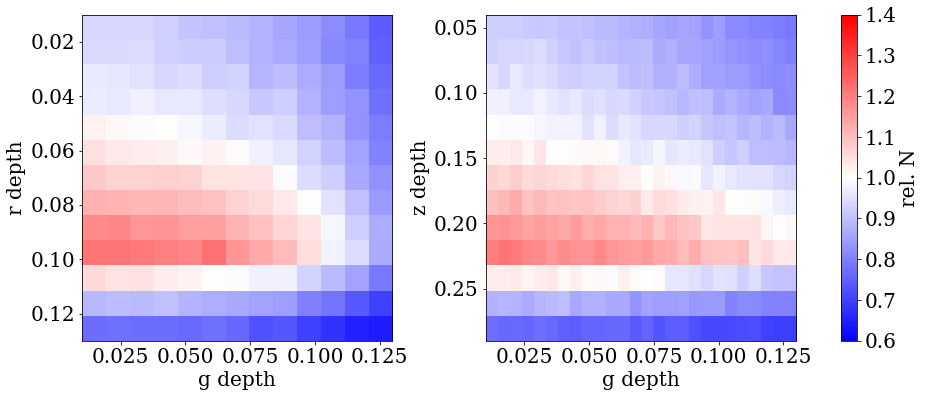

In [7]:
# figure
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
fig.subplots_adjust(wspace=0.3)
kw   = dict(vmin=0.6, vmax=1.4, aspect='auto', 
            interpolation='none', cmap=plt.cm.bwr)

# depth-g vs depth-r
map1 = ax[0].imshow(nzgrz[6,:,:, 10]/nzgrz[6,6,6,13],
                    extent=[0.01, 0.13, 0.13, 0.01], **kw)

# depth-g vs depth-z
map2 = ax[1].imshow(nzgrz[6,:,6, :]/nzgrz[6,6,6,13], 
                    extent=[0.01, 0.13, 0.29, 0.04], **kw)

# annotation
ax[0].set(xlabel='g depth', ylabel='r depth')
ax[1].set(xlabel='g depth', ylabel='z depth')
fig.colorbar(map1, ax=ax, label='rel. N')

### rel N(z) vs z

Text(0, 0.5, 'number ratio')

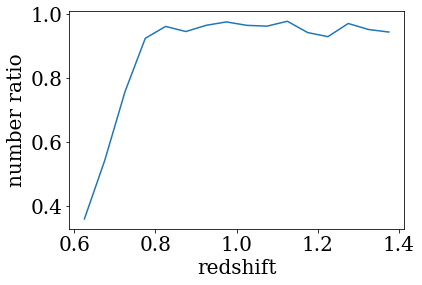

In [8]:
plt.plot(z_bin_mid, nzgrz[:,3,3,10]/nzgrz[:,6,6,13])
plt.xlabel('redshift')
plt.ylabel('number ratio')

## Part 2: Associate the N(z)s to the Imaging maps

Read the imaging attributes in Healpix, and evaluate the fluctuations in depth_r,g,z of the pixels.

In [9]:
#read in DR8 properties map
#pixfn      = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
pixfn      = '/home/mehdi/data/pixweight-dr8-0.31.1.fits' # Mehdi's local pc
pix,header = fitsio.read(pixfn,header=True)
HPXNSIDE   = header["HPXNSIDE"]
ii = np.where((pix["GALDEPTH_G"]>0)&(pix["GALDEPTH_R"]>0)&(pix["GALDEPTH_Z"]>0)&(pix["FRACAREA"]>0.01))[0]
npix=ii.size

print('columns=', pix.dtype.names)
print('number of pixels (before cut)=', pix.size)
print('number of pixels (after cut) =', npix)
pix = pix[ii]

depth_keyword="PSFDEPTH"
# gdepth=-2.5*np.log10(5/np.sqrt(pix[depth_keyword+"_G"]))+22.5
# rdepth=-2.5*np.log10(5/np.sqrt(pix[depth_keyword+"_R"]))+22.5
# zdepth=-2.5*np.log10(5/np.sqrt(pix[depth_keyword+"_Z"]))+22.5


R_G=3.214 # http://legacysurvey.org/dr8/catalogs/#galactic-extinction-coefficients
R_R=2.165
R_Z=1.211
gsigma=1./np.sqrt(pix[depth_keyword+"_G"])
rsigma=1./np.sqrt(pix[depth_keyword+"_R"])
zsigma=1./np.sqrt(pix[depth_keyword+"_Z"])


Gsig = gsigma*10**(0.4*R_G*pix["EBV"])
Rsig = rsigma*10**(0.4*R_R*pix["EBV"])
Zsig = zsigma*10**(0.4*R_Z*pix["EBV"])

columns= ('HPXPIXEL', 'FRACAREA', 'STARDENS', 'EBV', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'PSFDEPTH_W1', 'PSFDEPTH_W2', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'ELG', 'LRG', 'QSO', 'BGS_ANY', 'MWS_ANY', 'ALL', 'STD_FAINT', 'STD_BRIGHT', 'LRG_1PASS', 'LRG_2PASS', 'BGS_FAINT', 'BGS_BRIGHT', 'BGS_WISE', 'MWS_BROAD', 'MWS_MAIN_RED', 'MWS_MAIN_BLUE', 'MWS_WD', 'MWS_NEARBY')
number of pixels (before cut)= 786432
number of pixels (after cut) = 374065


Use KDTree to find the closest grid points to each observation

In [10]:
from sklearn.neighbors import KDTree

In [15]:
t0 = time()

position_grz = np.column_stack([Gsig, Rsig, Zsig])

# prepare the grid points
GRZsig_grid  = np.meshgrid(gsig, rsig, zsig)
GRZsig_grid  = np.column_stack([GRZsig_grid[i].ravel() for i in range(3)]) # 3: r, g, z


MyTree    = KDTree(GRZsig_grid, leaf_size=3)
dist, ind = MyTree.query(position_grz)
ind       = ind.flatten()

# reshape except the first axis ie. redshift
mynzrgz = nzgrz.reshape(nzgrz.shape[0], -1) 

# assign the N(z)
Nz_at_pos = mynzrgz[:, ind]

print(time()-t0, 'sec')

0.6753067970275879 sec


Let's save the N(Z) for each healpix pixel

In [16]:
Nz_at_pos, Nz_at_pos.shape

(array([[ 33.9,  40.3,  37.4, ...,  75.9,  75.9,  50.5],
        [ 72.1,  81.8,  75.1, ..., 124.7, 124.7,  92.4],
        [133.1, 134.9, 131.8, ..., 155.7, 155.7, 141.9],
        ...,
        [574. , 567.2, 573.7, ..., 578.4, 578.4, 566.3],
        [193.7, 192.9, 197.1, ..., 206.2, 206.2, 194.7],
        [246.9, 244.4, 245.2, ..., 249.8, 249.8, 244.1]]), (16, 374065))

In [20]:
output = np.empty(pix['HPXPIXEL'].size, dtype=[('HPIXPIXEL', 'int32'),
                                              ('Nz', ('f8', Nz_at_pos.shape[0]))])
output['HPIXPIXEL'] = pix['HPXPIXEL']
output['Nz']        = Nz_at_pos.T # reshape to [# pix, # z bins]
fitsio.write('Nz_pixweight-dr8-0.31.1.fits', output, clobber=True)

In [21]:
out = fitsio.read('Nz_pixweight-dr8-0.31.1.fits')

In [22]:
out

array([(     0, [ 33.9,  72.1, 133.1, 542.9, 825.5, 521.7, 440.7, 493.4, 508.2, 323.5, 559. , 393.7, 323.4, 574. , 193.7, 246.9]),
       (     1, [ 40.3,  81.8, 134.9, 535.6, 809.6, 519. , 442.7, 492. , 517.8, 327.3, 555.8, 389.2, 320.9, 567.2, 192.9, 244.4]),
       (     2, [ 37.4,  75.1, 131.8, 536.4, 810.4, 515.8, 444.1, 489.5, 513.6, 326.6, 559.1, 385.2, 316.7, 573.7, 197.1, 245.2]),
       ...,
       (786429, [ 75.9, 124.7, 155.7, 548.5, 816.6, 530. , 457.4, 503.6, 529.6, 328.6, 566.7, 398.8, 339.2, 578.4, 206.2, 249.8]),
       (786430, [ 75.9, 124.7, 155.7, 548.5, 816.6, 530. , 457.4, 503.6, 529.6, 328.6, 566.7, 398.8, 339.2, 578.4, 206.2, 249.8]),
       (786431, [ 50.5,  92.4, 141.9, 551.5, 823.8, 519.1, 447.5, 495.4, 520.8, 329.2, 554. , 393.6, 322.3, 566.3, 194.7, 244.1])],
      dtype=[('HPIXPIXEL', '>i4'), ('Nz', '>f8', (16,))])